In [163]:
import numpy as np
import scanpy.api as sc
import pandas as pd
import pylab
import matplotlib.pyplot as plt
from collections import Counter
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import os
import gseapy

from ete3 import Tree
import networkx as nx

import pickle as pic

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.stats.multitest as multi

import scipy.stats as scs

from tqdm import tqdm_notebook

import utilities.metastasis_score_utils as met_utils
from cassiopeia.TreeSolver import data_pipeline
from cassiopeia.TreeSolver.Cassiopeia_Tree import Cassiopeia_Tree

#from fitch_parsimony import *

#from Cassiopeia.TreeSolver import data_pipeline

np.set_printoptions(threshold=np.nan)

In [164]:
dfAT = pd.read_csv("/home/mattjones/projects/metastasis/JQ19/5k/ALL.5k.FINISHED.alleleTable.txt", sep='\t')
meta = pd.read_csv("/home/mattjones/projects/metastasis/JQ19/5k/ALL.5k.meta.txt", sep='\t', index_col = 0)

## Compute basic statistics

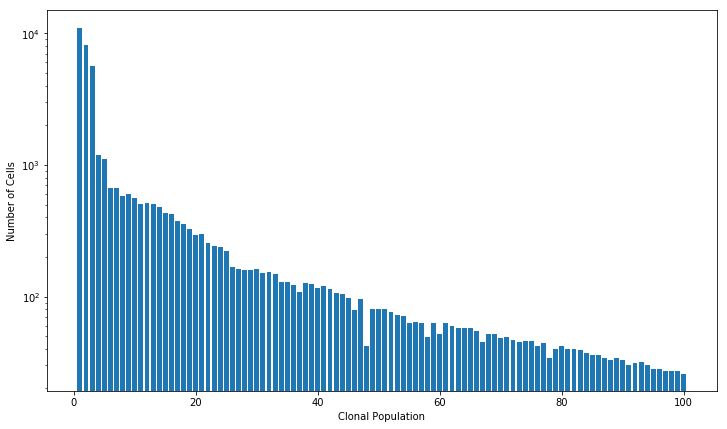

In [165]:
lg_sizes = dfAT.groupby("LineageGroup").agg({"cellBC": 'nunique'})

h = plt.figure(figsize=(12,7))
plt.bar(lg_sizes.index, lg_sizes['cellBC'])
plt.yscale('log')
plt.xlabel("Clonal Population")
plt.ylabel("Number of Cells")
plt.savefig('lg_sizes.png')
plt.show()

<Figure size 504x1080 with 0 Axes>

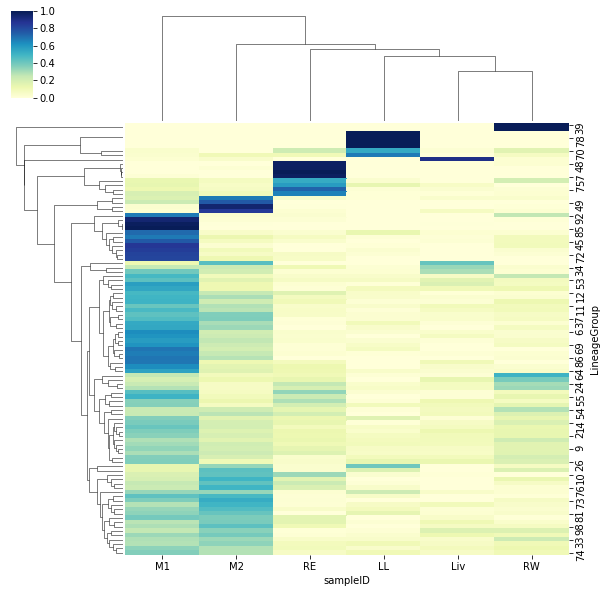

In [166]:
meta['BC'] = meta.index
samp_piv = pd.pivot_table(meta, index='LineageGroup', columns = 'sampleID', values = 'BC', aggfunc='count')

samp_piv.fillna(0, inplace=True)
samp_piv = samp_piv.apply(lambda x: x / x.sum(), axis=1)

h = plt.figure(figsize = (7,15))
sns.clustermap(samp_piv, cmap='YlGnBu')
plt.savefig("lg_sample_dist.png")
plt.show()

## First perform filtering

In [167]:

dfAT_rtot = dfAT.groupby(["cellBC","LineageGroup"]).agg({"r1.old":'count'}).rename(index=str, columns={'r1.old':'r.tot'})
dfAT_r1unc = dfAT[dfAT['r1.old'].str.contains("None")].groupby(["cellBC","LineageGroup"]).agg({"r1.old":'count'}).rename(index=str, columns={'r1.old':'r1.uncut'})
dfAT_r2unc = dfAT[dfAT['r2.old'].str.contains("None")].groupby(["cellBC","LineageGroup"]).agg({"r2.old":'count'}).rename(index=str, columns={'r2.old':'r2.uncut'})
dfAT_r3unc = dfAT[dfAT['r3.old'].str.contains("None")].groupby(["cellBC","LineageGroup"]).agg({"r3.old":'count'}).rename(index=str, columns={'r3.old':'r3.uncut'})

dfCUT = pd.concat([dfAT_rtot,dfAT_r1unc,dfAT_r2unc,dfAT_r3unc], axis=1)
dfCUT = dfCUT.fillna(0)
dfCUT = dfCUT.sort_values("LineageGroup")

dfCUT['r1.cut%'] = 1-(dfCUT['r1.uncut']/dfCUT['r.tot'])
dfCUT['r2.cut%'] = 1-(dfCUT['r2.uncut']/dfCUT['r.tot'])
dfCUT['r3.cut%'] = 1-(dfCUT['r3.uncut']/dfCUT['r.tot'])

dfCUT['cut%'] = (dfCUT['r1.cut%']+dfCUT['r2.cut%']+dfCUT['r3.cut%'])/3

X1 = dfCUT.groupby(['LineageGroup']).agg({'r1.cut%':'mean'})
X2 = dfCUT.groupby(['LineageGroup']).agg({'r2.cut%':'mean'})
X3 = dfCUT.groupby(['LineageGroup']).agg({'r3.cut%':'mean'})

XCUT = pd.concat([X1,X2,X3], axis=1).reset_index()
XCUT.LineageGroup = pd.to_numeric(XCUT.LineageGroup, errors='coerce')
XCUT = XCUT.sort_values("LineageGroup").set_index("LineageGroup")

cut_rates = XCUT.sum(1)/3

cut_rates.to_csv("data/cutRateByLG.5k.txt", sep='\t')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


In [168]:
# cut_rates = pd.read_csv("data/cutRateByLG.5k.txt", sep='\t', header=None, index_col = 0)

labels = []
tree_fps = []
lg_to_tree = {}
i = 0
for tree_dir in tqdm_notebook(os.listdir("/home/mattjones/projects/metastasis/JQ19/5k/trees")):
    tree_dir = "/home/mattjones/projects/metastasis/JQ19/5k/trees/" + tree_dir + "/"
    if not os.path.isdir(tree_dir):
        continue
    
    lg = tree_dir.split("/")[-2][2:]
    #fps = [fp for fp in os.listdir(tree_dir) if ".txt" in fp and 'tree' in fp and 'nj' not in fp and 'processed' not in fp]
    fps = [fp for fp in os.listdir(tree_dir) if ".processed.pkl" in fp and 'nj' not in fp]
    cmfp = [fp for fp in os.listdir(tree_dir) if "_character_matrix.txt" in fp]
    if len(fps) > 0:
            try:
                tree = nx.read_gpickle(tree_dir + fps[0])
                lg_to_tree[int(lg)] = tree
                tree_fps.append(tree_dir + fps[0])
                cmfp = tree_dir + cmfp[0]
                labels.append(int(lg))
                cm = pd.read_csv(cmfp, sep='\t', index_col = 0, dtype=str)
            except:
                i += 1
            #tree = Cassiopeia_Tree('from_newick', network = data_pipeline.newick_to_network(tree_dir + fps[0], cm))
            #lg_to_tree[int(lg)] = tree.post_process(cm)
print(i)    


17


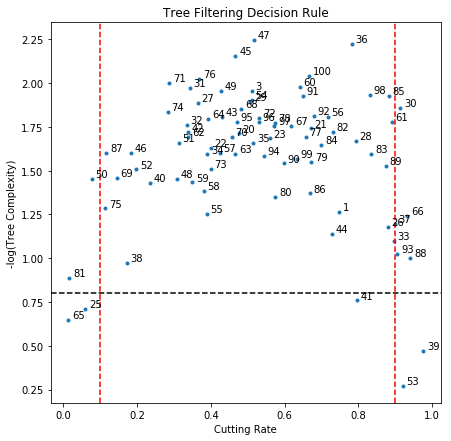

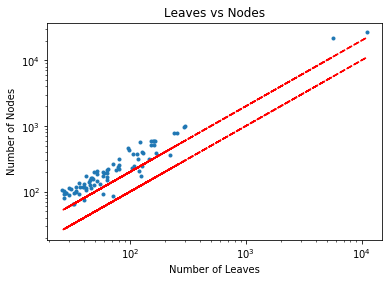

{65, 66, 39, 41, 81, 50, 53, 88, 25, 93, 30} 11


In [169]:
complexities = []
crs = []
num_leaves = []
num_nodes = []
for lg in tqdm_notebook(lg_to_tree.keys()):
    
    crs.append(cut_rates.loc[lg])
    tree_complexity = met_utils.compute_tree_complexity(lg_to_tree[lg].network)
    complexities.append(tree_complexity[0])
    num_leaves.append(tree_complexity[1])
    num_nodes.append(tree_complexity[2])

    
tree_stats = pd.DataFrame(index = lg_to_tree.keys(), columns = ["CutRate", "TreeComplexity"])
tree_stats["CutRate"] = crs
tree_stats["TreeComplexity"] = complexities
tree_stats["NumLeaves"] = num_leaves
tree_stats["NumNodes"] = num_nodes

h = plt.figure(figsize=(7,7))
plt.plot(tree_stats["CutRate"], -np.log2(tree_stats["TreeComplexity"]), '.')
plt.axvline(x = 0.1, color="red", linestyle="dashed")
plt.axvline(x = 0.9, color="red", linestyle="dashed")
plt.axhline(y = 0.8, color="black", linestyle="dashed")
plt.xlabel("Cutting Rate")
plt.ylabel("-log(Tree Complexity)")
plt.title("Tree Filtering Decision Rule")

for i in tree_stats.index:
    plt.annotate(i, (tree_stats.loc[i, "CutRate"]+0.01, -np.log2(tree_stats.loc[i, "TreeComplexity"]) + 0.01))

plt.show()

plt.plot(tree_stats["NumLeaves"], tree_stats["NumNodes"], ".")
plt.title("Leaves vs Nodes")
plt.xlabel("Number of Leaves")
plt.ylabel("Number of Nodes")
plt.plot(tree_stats["NumLeaves"], tree_stats["NumLeaves"], color = "red", linestyle="dashed")
plt.plot(tree_stats["NumLeaves"], 2*tree_stats["NumLeaves"], color = "red", linestyle="dashed")
plt.loglog()
plt.show()


to_drop = list(tree_stats[(tree_stats["CutRate"] >= 0.9) | (tree_stats["CutRate"] <= 0.1)].index)
to_drop += list(tree_stats[(-np.log2(tree_stats["TreeComplexity"]) <= 0.8)].index)

print(set(to_drop), len(set(to_drop)))

/home/mattjones/projects/metastasis/MetastasisTracing/utilities/metastasis_score_utils.py:78: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  table = pd.concat([background, query], axis=1)


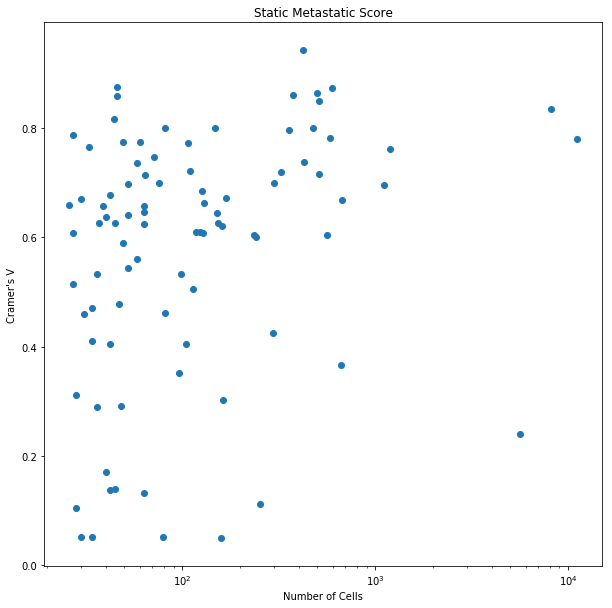

In [170]:
background = {}
for n, g in meta.groupby("sampleID"):
    background[n] = g.shape[0]
    
background = pd.DataFrame.from_dict(background, orient="index")

static_stats = {}
for n, g in tqdm_notebook(meta.groupby(["LineageGroup"])):

    if n in to_drop:
        continue
    
    stats = met_utils.compute_static_metastasis_score(g, background,  group_var = 'sampleID')
    
    static_stats[n] = tuple(stats)
    
colormap = ["blue"] * len(static_stats)
colormap[0] = "red"
colormap[1] = "green"
colormap[3] = "black"
colormap[5] = 'orange'
colormap[35] = "black"

sizes = dict(zip(static_stats.keys(), list(map(lambda x: x[0], static_stats.values()))))
ss = dict(zip(static_stats.keys(), list(map(lambda x: 1 - x[3], static_stats.values()))))
labs = static_stats.keys()
# labs = [0, 1, 3, 5, 35]

h = plt.figure(figsize = (10, 10))
plt.scatter(sizes.values(), ss.values())
plt.xscale('log')
plt.xlabel("Number of Cells")
plt.ylabel("Cramer's V")
plt.title("Static Metastatic Score")

#for i in labs:
#    plt.annotate(i, (sizes[i]+0.05, ss[i]+0.01))

plt.savefig("figs/static_met_score.png")
plt.show()

## Compute the dynamic metastatic score

In [179]:
evolving_scores = {}
nn_scores = {}
lg_to_fitch = {}            
for n in tqdm_notebook(labels):

    if n not in to_drop:
        print(n)
        tree = lg_to_tree[n].network
        evolving_scores[n] = met_utils.compute_dynamic_metastasis_score(tree, meta['sampleID'])
        nn_scores[n] = met_utils.compute_NN_metastasis_score(tree, meta['sampleID'], verbose=False)

    
    

21


Creating pairs to compare: 100%|██████████| 299/299 [00:00<00:00, 13544.33it/s]


100


Creating pairs to compare: 100%|██████████| 26/26 [00:00<00:00, 38358.04it/s]


56


Creating pairs to compare: 100%|██████████| 64/64 [00:00<00:00, 64295.92it/s]


80


Creating pairs to compare: 100%|██████████| 42/42 [00:00<00:00, 79137.81it/s]


64


Creating pairs to compare: 100%|██████████| 58/58 [00:00<00:00, 62811.68it/s]


32


Creating pairs to compare: 100%|██████████| 153/153 [00:00<00:00, 28552.99it/s]


45


Creating pairs to compare: 100%|██████████| 98/98 [00:00<00:00, 41393.94it/s]


38


Creating pairs to compare: 100%|██████████| 126/126 [00:00<00:00, 35841.46it/s]


77


Creating pairs to compare: 100%|██████████| 44/44 [00:00<00:00, 86318.70it/s]


99


Creating pairs to compare: 100%|██████████| 27/27 [00:00<00:00, 97374.21it/s]


1


Creating pairs to compare: 100%|██████████| 11053/11053 [01:06<00:00, 165.79it/s]


70


Creating pairs to compare: 100%|██████████| 48/48 [00:00<00:00, 27857.56it/s]


94


Creating pairs to compare: 100%|██████████| 30/30 [00:00<00:00, 56400.32it/s]


42


Creating pairs to compare: 100%|██████████| 114/114 [00:00<00:00, 27274.58it/s]


35


Creating pairs to compare: 100%|██████████| 128/128 [00:00<00:00, 32914.65it/s]


48


Creating pairs to compare: 100%|██████████| 42/42 [00:00<00:00, 87122.04it/s]


69


Creating pairs to compare: 100%|██████████| 52/52 [00:00<00:00, 82740.44it/s]


87


Creating pairs to compare: 100%|██████████| 34/34 [00:00<00:00, 52993.81it/s]


63


Creating pairs to compare: 100%|██████████| 58/58 [00:00<00:00, 48096.01it/s]


51


Creating pairs to compare: 100%|██████████| 81/81 [00:00<00:00, 53409.62it/s]


26


Creating pairs to compare: 100%|██████████| 169/169 [00:00<00:00, 23721.22it/s]


55


Creating pairs to compare: 100%|██████████| 63/63 [00:00<00:00, 48043.85it/s]


22


Creating pairs to compare: 100%|██████████| 253/253 [00:00<00:00, 16863.60it/s]


28


Creating pairs to compare: 100%|██████████| 160/160 [00:00<00:00, 25733.90it/s]


89


Creating pairs to compare: 100%|██████████| 34/34 [00:00<00:00, 51631.55it/s]


67


Creating pairs to compare: 100%|██████████| 45/45 [00:00<00:00, 63678.70it/s]


83


Creating pairs to compare: 100%|██████████| 39/39 [00:00<00:00, 87055.80it/s]


46


Creating pairs to compare: 100%|██████████| 79/79 [00:00<00:00, 52082.68it/s]


31


Creating pairs to compare: 100%|██████████| 151/151 [00:00<00:00, 29296.88it/s]


90


Creating pairs to compare: 100%|██████████| 33/33 [00:00<00:00, 66865.72it/s]


74


Creating pairs to compare: 100%|██████████| 46/46 [00:00<00:00, 87183.91it/s]


97


Creating pairs to compare: 100%|██████████| 27/27 [00:00<00:00, 59950.35it/s]


79


Creating pairs to compare: 100%|██████████| 40/40 [00:00<00:00, 68956.91it/s]


73


Creating pairs to compare: 100%|██████████| 45/45 [00:00<00:00, 78939.22it/s]


36


Creating pairs to compare: 100%|██████████| 123/123 [00:00<00:00, 32059.37it/s]


60


Creating pairs to compare: 100%|██████████| 52/52 [00:00<00:00, 86037.01it/s]


84


Creating pairs to compare: 100%|██████████| 37/37 [00:00<00:00, 53978.87it/s]


52


Creating pairs to compare: 100%|██████████| 76/76 [00:00<00:00, 39315.13it/s]


58


Creating pairs to compare: 100%|██████████| 49/49 [00:00<00:00, 55129.00it/s]


62


Creating pairs to compare: 100%|██████████| 60/60 [00:00<00:00, 57508.74it/s]


68


Creating pairs to compare: 100%|██████████| 52/52 [00:00<00:00, 54607.86it/s]


86


Creating pairs to compare: 100%|██████████| 36/36 [00:00<00:00, 52721.70it/s]


27


Creating pairs to compare: 100%|██████████| 162/162 [00:00<00:00, 25527.94it/s]


95


Creating pairs to compare: 100%|██████████| 28/28 [00:00<00:00, 66538.53it/s]


71


Creating pairs to compare: 100%|██████████| 49/49 [00:00<00:00, 67716.93it/s]


49


Creating pairs to compare: 100%|██████████| 81/81 [00:00<00:00, 38379.87it/s]


34


Creating pairs to compare: 100%|██████████| 130/130 [00:00<00:00, 35019.88it/s]


43


Creating pairs to compare: 100%|██████████| 107/107 [00:00<00:00, 39631.80it/s]


44


Creating pairs to compare: 100%|██████████| 105/105 [00:00<00:00, 34866.75it/s]


33


Creating pairs to compare: 100%|██████████| 147/147 [00:00<00:00, 28364.66it/s]


92


Creating pairs to compare: 100%|██████████| 31/31 [00:00<00:00, 33869.09it/s]


76


Creating pairs to compare: 100%|██████████| 42/42 [00:00<00:00, 64646.15it/s]


98


Creating pairs to compare: 100%|██████████| 27/27 [00:00<00:00, 56285.39it/s]


57


Creating pairs to compare: 100%|██████████| 63/63 [00:00<00:00, 41956.36it/s]


20


Creating pairs to compare: 100%|██████████| 294/294 [00:00<00:00, 13970.56it/s]


85


Creating pairs to compare: 100%|██████████| 36/36 [00:00<00:00, 88872.83it/s]


61


Creating pairs to compare: 100%|██████████| 63/63 [00:00<00:00, 51579.38it/s]


59


Creating pairs to compare: 100%|██████████| 63/63 [00:00<00:00, 34947.91it/s]


72


Creating pairs to compare: 100%|██████████| 47/47 [00:00<00:00, 65275.59it/s]


96


Creating pairs to compare: 100%|██████████| 28/28 [00:00<00:00, 96341.68it/s]


78


Creating pairs to compare: 100%|██████████| 34/34 [00:00<00:00, 54533.97it/s]


3


Creating pairs to compare: 100%|██████████| 5616/5616 [00:13<00:00, 415.15it/s]


40


Creating pairs to compare: 100%|██████████| 117/117 [00:00<00:00, 25400.29it/s]


37


Creating pairs to compare: 100%|██████████| 109/109 [00:00<00:00, 38286.50it/s]


47


Creating pairs to compare: 100%|██████████| 96/96 [00:00<00:00, 48500.74it/s]


75


Creating pairs to compare: 100%|██████████| 46/46 [00:00<00:00, 82487.38it/s]


91


Creating pairs to compare: 100%|██████████| 30/30 [00:00<00:00, 88862.37it/s]


29


Creating pairs to compare: 100%|██████████| 159/159 [00:00<00:00, 23507.03it/s]


23


Creating pairs to compare: 100%|██████████| 241/241 [00:00<00:00, 17319.96it/s]


54


Creating pairs to compare: 100%|██████████| 71/71 [00:00<00:00, 60258.11it/s]


82


Creating pairs to compare: 100%|██████████| 40/40 [00:00<00:00, 87381.33it/s]


[93, 25, 50, 39, 65, 81, 53, 30, 88, 66, 41, 25, 39, 65, 53]


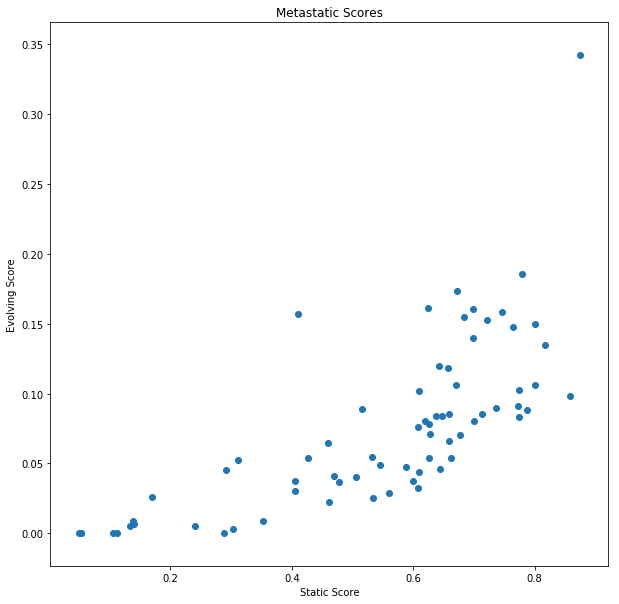

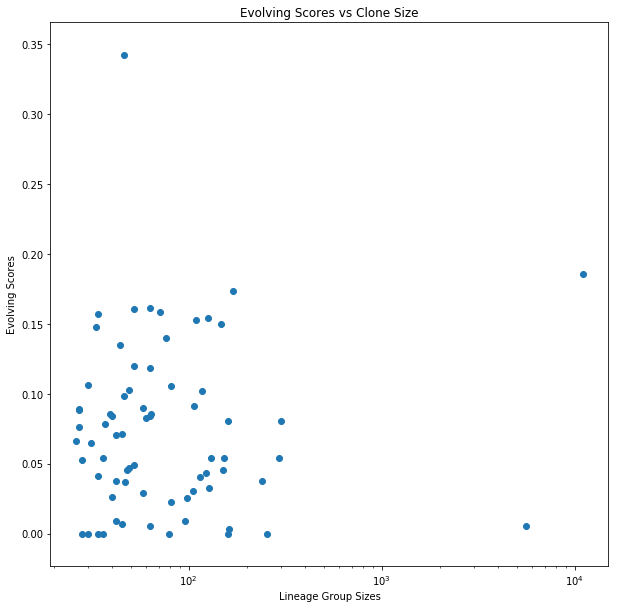

In [180]:
subset_static_scores = {}
for k in evolving_scores.keys():
    subset_static_scores[k] = static_stats[k]
    
ss = list(map(lambda x: 1 - x[3], subset_static_scores.values()))
sizes = list(map(lambda x: x[0], subset_static_scores.values()))
es = list(evolving_scores.values())
#labs = [2, 3, 4, 5, 6, 10, 12, 16, 21, 35, 39, 40, 52, 77, 84]
    
h = plt.figure(figsize = (10, 10))
plt.scatter(ss, es)
plt.xlabel("Static Score")
plt.ylabel("Evolving Score")
plt.title("Metastatic Scores")

#for i, txt in enumerate(subset_static_scores.keys()):
#    plt.annotate(txt, (ss[i]+0.001, es[i]+0.001))
    
plt.savefig("figs/static_vs_evolving.png")


h = plt.figure(figsize = (10, 10))
plt.scatter(sizes, es)
plt.xscale('log')
plt.xlabel("Lineage Group Sizes")
plt.ylabel("Evolving Scores")
plt.title("Evolving Scores vs Clone Size")

#for i, txt in enumerate(subset_static_scores.keys()):
#    plt.annotate(txt, (sizes[i]+0.001, es[i]+0.001))
    
plt.savefig("figs/dynamic_met_scores.png")

print(to_drop)

In [181]:
print(len(nn_scores.keys()))

71


[93, 25, 50, 39, 65, 81, 53, 30, 88, 66, 41, 25, 39, 65, 53]


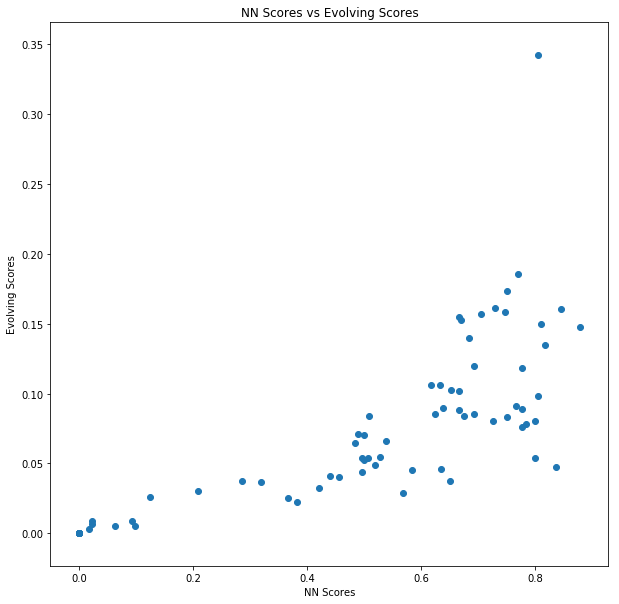

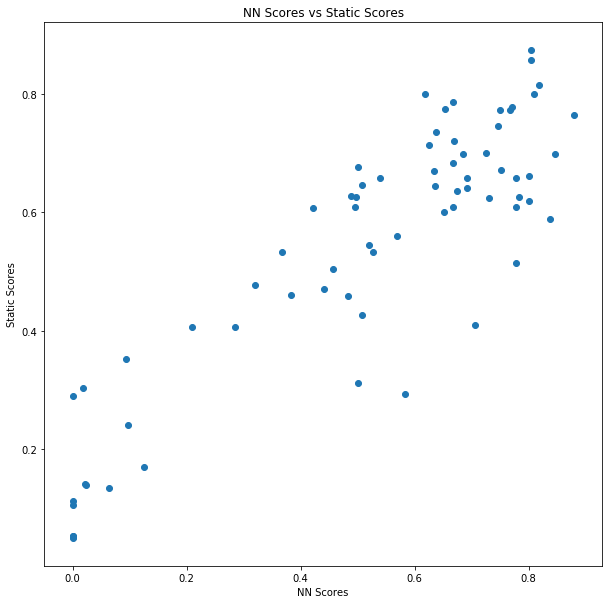

In [185]:
subset_evolving_scores = {}
subset_static_scores = {}
for k in nn_scores.keys():
    subset_evolving_scores[k] = evolving_scores[k]
    subset_static_scores[k] = static_stats[k]

ns = list(nn_scores.values())
es2 = list(subset_evolving_scores.values())
ss2 = list(map(lambda x: 1 - x[3], subset_static_scores.values()))
#labs = [2, 3, 4, 5, 6, 10, 12, 16, 21, 35, 39, 40, 52, 77, 84]
    

h = plt.figure(figsize = (10, 10))
plt.scatter(ns, es2)
plt.xlabel("NN Scores")
plt.ylabel("Evolving Scores")
plt.title("NN Scores vs Evolving Scores")

#for i, txt in enumerate(subset_static_scores.keys()):
#    plt.annotate(txt, (sizes[i]+0.001, es[i]+0.001))
    
plt.savefig("figs/nn_vs_evolvscores.png")

h = plt.figure(figsize = (10, 10))
plt.scatter(ns, ss2)
plt.xlabel("NN Scores")
plt.ylabel("Static Scores")
plt.title("NN Scores vs Static Scores")

plt.savefig("figs/nn_vs_staticscores.png")


print(to_drop)

In [183]:
met_scores = pd.DataFrame([ss, es]).T
met_scores.index = evolving_scores.keys()
met_scores.columns = ["Static", "Dynamic"]
met_scores['NearestNeighbor'] = met_scores.apply(lambda x: nn_scores[x.name] if x.name in nn_scores.keys() else None, axis=1)

met_scores.to_csv("data/lg_metastatic_scores.txt", sep='\t')